# Video Category : LDA Topic Modeling with Hyperparameter Tuning

This notebook demonstrates topic modeling on YouTube video comments using Latent Dirichlet Allocation (LDA). The workflow includes data loading, preprocessing, vectorization, LDA model training with hyperparameter tuning, topic assignment, and visualization. Each step is documented with markdown and code comments for clarity and reproducibility.

## Import Required Libraries
Import all necessary libraries for data manipulation, topic modeling, and visualization. This includes pandas, numpy, scikit-learn, tqdm, joblib, re, and matplotlib.

In [ ]:
# Import all required libraries for data processing, topic modeling, and visualization
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Enable tqdm for pandas apply
# This allows progress bars for pandas operations

tqdm.pandas()

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Show full text and more rows in pandas outputs
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 500)

## Load Cleaned and Translated Video 
Read the preprocessed video dataset from a CSV file into a pandas DataFrame for further analysis.

In [ ]:
# Load the cleaned and translated video comments dataset
df = pd.read_csv('dataset/videos_cleaned_translated.csv')

## Check Dataset Shape
Display the number of rows and columns in the loaded DataFrame to confirm successful loading and understand dataset size.

In [ ]:
# Display the shape of the DataFrame to check the number of rows and columns
df.shape

(91113, 16)

## Convert Video to List
Extract the 'translated' column from the DataFrame, drop missing values, and convert the comments to a list for vectorization.

In [ ]:
# Extract the 'translated' video title, drop missing values, and convert to a list for vectorization
corpus = df['translated'].dropna().astype(str).tolist()

## Vectorize Video Title for LDA
Transform the list of video title into a document-term matrix using CountVectorizer, which is suitable for LDA topic modeling.

In [ ]:
# Vectorize the comments using CountVectorizer for LDA
# This creates a document-term matrix suitable for topic modeling
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus)

## Hyperparameter Tuning with GridSearch (Optional)
Set up a grid search to find the best LDA hyperparameters (number of topics, learning decay) using cross-validation. This step is commented out for reference.

In [ ]:
# (Optional) Use GridSearchCV to tune LDA hyperparameters
# Uncomment and run this section to perform hyperparameter tuning
# search_params = {
#     'n_components': [5, 10, 15],
#     'learning_decay': [0.5, 0.7, 0.9]
# }
# lda = LatentDirichletAllocation(max_iter=10, learning_method='online', random_state=42)
# model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1, verbose=1)
# print("Running GridSearch on FULL dataset (CountVectorizer)...")
# model_countvectorizer = model.fit(count_data_vectorized)

## Extract Best Model from GridSearch (Optional)
Retrieve the best LDA model and its parameters from the grid search results. This step is also commented out for reference.

In [ ]:
# (Optional) Extract the best LDA model and its parameters from GridSearchCV
# Uncomment and run if GridSearch was performed
# best_lda_model_count = model_countvectorizer.best_estimator_
# print("Best Params (CountVectorizer):", model_countvectorizer.best_params_)
# print("Best Log Likelihood Score (Count):", model_countvectorizer.best_score_)

## Train Final LDA Model with Best Parameters
Fit the LDA model on the full dataset using the best parameters. Evaluate the model using log likelihood and perplexity.

In [ ]:
# Train the final LDA model using the best parameters
final_lda = LatentDirichletAllocation(
    n_components=5,  # Number of topics
    learning_decay=0.7,  # Learning decay rate
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit the final model on the full dataset
topic_distributions = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model using log likelihood and perplexity
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

# topic_distributions contains document-topic distributions
print("Shape of document-topic matrix:", topic_distributions.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -5062103.915586443
Perplexity: 2094.8013971227783
Shape of document-topic matrix: (91071, 5)


## Topic Analysis
Analyze the topics generated by the LDA model, including extracting top keywords for each topic and visualizing topic distributions.

### Define Function to Print Topics
Create a function to display the top keywords for each topic, optionally showing their probabilities.

In [ ]:
# Define a function to print the top keywords for each topic
# Optionally display probabilities for each keyword
def print_topics(model, vectorizer, top_n=10, show_probs=True):
    keywords_per_topic = {}
    feature_names = vectorizer.get_feature_names_out()
    
    # Normalize components_ to probabilities (P(word | topic))
    topic_word_prob = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    for idx, topic in enumerate(topic_word_prob):
        top_features = topic.argsort()[:-top_n - 1:-1]
        
        if show_probs:
            top_words = [(feature_names[i], round(topic[i], 4)) for i in top_features]
        else:
            # fallback to raw weights
            top_words = [(feature_names[i], round(model.components_[idx, i], 2)) for i in top_features]
        
        keywords_per_topic[f"Topic {idx+1}"] = top_words
        print(f"\nTopic {idx+1}: {top_words}")
    
    return keywords_per_topic

### Print LDA Topics with Probabilities
Display the top keywords for each topic, along with their probabilities, using the previously defined function.

In [ ]:
# Print the top keywords for each topic with their probabilities
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)

LDA Topics (with probabilities):

Topic 1: [('skin', np.float64(0.0475)), ('lip', np.float64(0.033)), ('beauty', np.float64(0.029)), ('body', np.float64(0.0191)), ('best', np.float64(0.0148)), ('serum', np.float64(0.014)), ('skincare', np.float64(0.0135)), ('care', np.float64(0.0112)), ('facial', np.float64(0.01)), ('science', np.float64(0.0097))]

Topic 2: [('makeup', np.float64(0.0899)), ('short', np.float64(0.0482)), ('look', np.float64(0.0291)), ('beauty', np.float64(0.025)), ('face', np.float64(0.0178)), ('skincare', np.float64(0.0137)), ('viral', np.float64(0.0136)), ('youtubeshorts', np.float64(0.0116)), ('makeuptutorial', np.float64(0.0107)), ('blush', np.float64(0.0103))]

Topic 3: [('perfume', np.float64(0.0143)), ('brow', np.float64(0.0138)), ('powder', np.float64(0.0113)), ('car', np.float64(0.0113)), ('beauty', np.float64(0.0108)), ('eyebrow', np.float64(0.0091)), ('setting', np.float64(0.0088)), ('video', np.float64(0.0081)), ('shine', np.float64(0.0078)), ('need', np.flo

### Assign Topics to Documents
Assign the most probable topic to each document and label topics with their top keyword for easier interpretation.

In [ ]:
# Assign a label to each topic based on its top keyword
# This helps interpret the topics more easily
feature_names = count_vectorizer.get_feature_names_out()
topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'skin', 1: 'makeup', 2: 'perfume', 3: 'hair', 4: 'body'}


### Assign Dominant Topic and Confidence to Each Document
For each comment, assign the most probable topic (dominant topic), the model's confidence in that assignment, and a human-readable topic label. This enables further analysis and interpretation of topic modeling results at the document level.

In [ ]:
# Initialize columns for topic assignment and confidence
df['dominant_topic'] = np.nan
df['topic_confidence'] = np.nan
df['topic_label'] = np.nan

# Mask for non-null rows
mask = df['translated'].notnull()

# Compute dominant topic and confidence for each document
dominant_topic = np.argmax(topic_distributions, axis=1)
topic_confidence = topic_distributions.max(axis=1)

# Assign results back to the DataFrame
df.loc[mask, 'dominant_topic'] = dominant_topic
df.loc[mask, 'topic_confidence'] = topic_confidence
df.loc[mask, 'topic_label'] = df.loc[mask, 'dominant_topic'].map(topic_labels)

### Display Sample of Topic Assignments
Show a random sample of 10 documents with their cleaned text, assigned dominant topic, topic label, and confidence score. This helps verify topic assignment quality and interpretability.

In [ ]:
# Display a sample of documents with their assigned topic and confidence
df[['cleanedText', 'dominant_topic', 'topic_label', 'topic_confidence']].sample(10)

,cleanedText,dominant_topic,topic_label,topic_confidence
31266,day3975 hair growth challenge glow short glowyourself 75dayshard 75hard viral,4.0,body,0.437587
32162,professional hair transformation jai hairwork trending short hair,3.0,hair,0.910893
16362,️age defying serum ️reels serumviralglowbeauty short skincare,0.0,skin,0.591176
20592,hairserum tresemmé hair haircare styling shortsindia short viral trending youtubeshorts,3.0,hair,0.759570
47722,look com calça legging inspiração para usar perfume kerastase lookdodia arrumesecomigo,3.0,hair,0.577836
13137,meredith duxbury foundation challenge,1.0,makeup,0.440039
32954,best lash serum,0.0,skin,0.517763
90514,best music 2023 makeup douyin hair care,3.0,hair,0.489471
79008,hair color say part 2 short,3.0,hair,0.839527
45279,lipstick gloss powdershaibirashik hack trending makeup short yt,1.0,makeup,0.789440


### Save Results to CSV
Remove any unnecessary index columns and save the DataFrame with topic assignments to a CSV file for future analysis or reporting.

In [ ]:
# Drop the 'Unnamed: 0' column if it exists and save the DataFrame to CSV
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df.to_csv("dataset/videos_with_topics_5.csv", index=False)
print("✅ Saved as videos_with_topics_5.csv (without Unnamed: 0).")

✅ Saved as comments_with_topics.csv (without Unnamed: 0).


### Visualize Topic Distribution
Create a pie chart to show the proportion of each topic in the dataset. This visualization helps to quickly understand the prevalence of different topics among the comments.

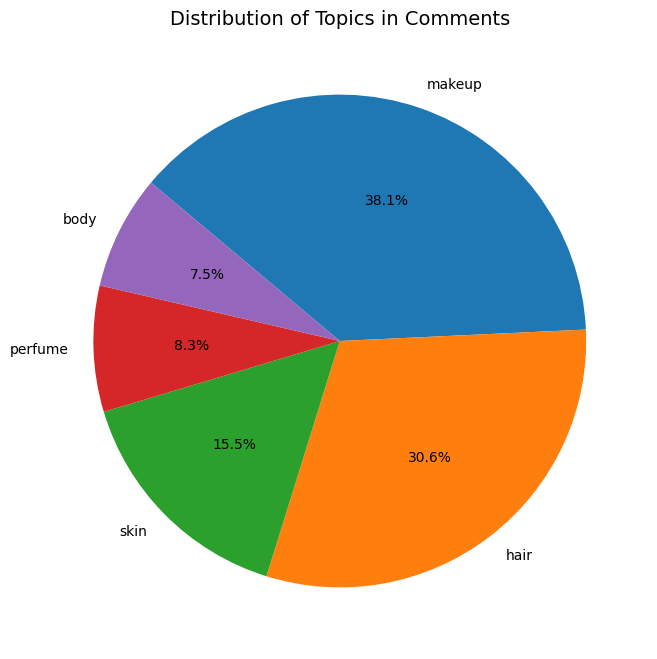

In [ ]:
# Visualize the distribution of topics in the comments using a pie chart
topic_counts = df['topic_label'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
plt.pie(
    topic_counts,
    labels=topic_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
plt.title("Distribution of Topics in Comments", fontsize=14)
plt.show()

### Visualize Topic Trends Over Time
Convert the 'publishedAt' column to datetime, group by month and topic, and plot topic frequency trends over time. This helps reveal how the prevalence of each topic changes across different periods.

<Axes: xlabel='publishedAt'>

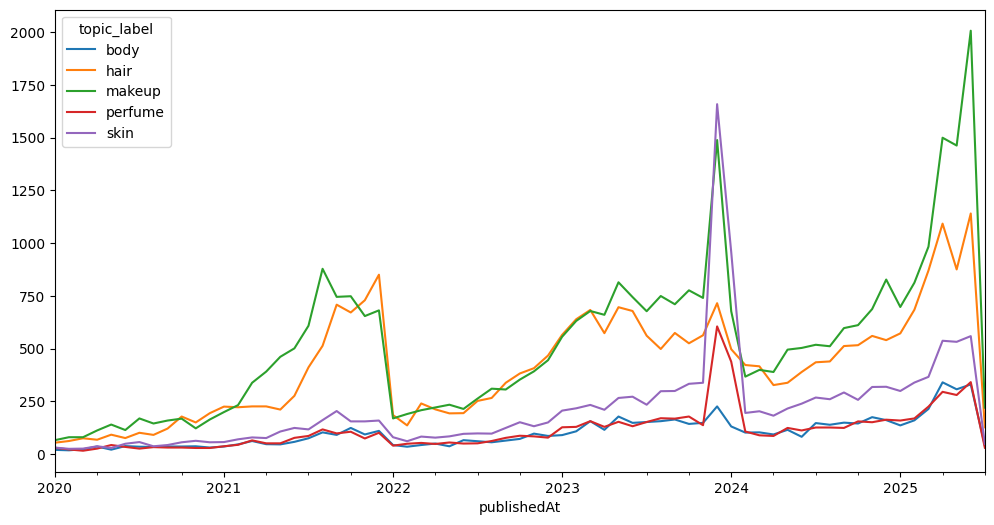

In [ ]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
topic_trends = df.groupby([df['publishedAt'].dt.to_period("M"), 'topic_label']).size().unstack().fillna(0)

topic_trends.plot(kind="line", figsize=(12,6))

### Save Topic Distributions to File
Export the document-topic matrix using joblib for efficient storage and future use, such as further analysis or model deployment.

In [ ]:

# Save the topic distributions (document-topic matrix) to a file for later use
joblib.dump(topic_distributions, "model/lda_model_with_8.pkl")

['lda_model_with_8.pkl']